In this notebook I want to present how Ridge Regression algorithm works. Special case of Linear Regression with L2 regularization. This implementation should not be used for real problems as it's slower than excelent available tools like e.g. sci-kit learn.

In [79]:
from sklearn.datasets import make_regression
from sklearn import linear_model

%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import numpy as np 

### Constants

In [80]:
DATA_NUM = 20

### Generate problem

In [81]:
def generate_ridge_regression_problem(bias, weight, samples_num):
    """Function to generate points that can be aproximated by linear function. 
    Anomalies will be included in data. Returns tuple of data and it's labels. 
    
    Arguments:
    ---------
    samples_num: int
        Numer of points that should be generated.
    """
    def _linear_function(bias, weight, x):
        """Implementation of linear function."""
        return weight * x + bias
    
    x_values = list()
    y_values = list()
    
    # Generating random linear points
    x_values_pool = np.arange(-5.0, 5.0, 0.001)
    while len(x_values) != samples_num:
        x_rand = np.random.choice(x_values_pool)
        x_values.append(x_rand)
        y_values.append(_linear_function(bias, weight, x_rand))
        
    # Adding noise to each point
    max_y = max(y_values)
    min_y = min(y_values)
    y_values = [y + np.random.uniform(low=-0.2*min_y, high=0.2*max_y) for y in y_values]
    
    # Adding few anomalies
    anomalies_num = int(np.ceil(0.2 * samples_num))
    for x in range(anomalies_num):
        x_rand = np.random.choice(x_values_pool)
        x_values.append(x_rand)
        y_anomaly = 5 * _linear_function(bias, weight, x_rand)
        y_values.append(y_anomaly)
 
    return np.array(x_values).reshape(-1, 1), np.array(y_values).reshape(-1, 1)

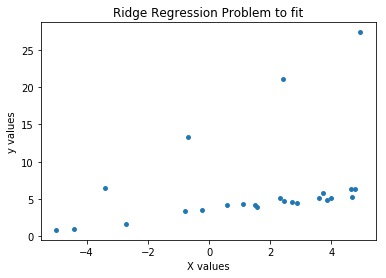

In [82]:
# Generating values 'X' and labels 'y'
X, y = generate_ridge_regression_problem(3, 0.5, DATA_NUM)

# Presenting generated data
plt.scatter(X, y, s=15)
plt.title("Ridge Regression Problem to fit")
plt.xlabel("X values")
plt.ylabel("y values")
plt.show()

### Ridge Regression -  Raw implementation

In [83]:
class RidgeRegression:
    """Ridge Regression model.
    
    Arguments:
    ---------
    iterations: int
        Number of Gradient Descent Steps that will be performed in order to change weights of
        linear model
    learning_rate: float
        Weight applied for Gradient Descent Step during updating weights. (default: 0.001)
    regularization_factor: float
        Value that will be increasing impact that large weights value has on model during
        Gradient Descent in order to optimize their shrinkage.
    normalize: boolean
        Flag for normalization. If set to true data will be scaled to values which mean is close
        to 0 and standard deviation close to 1. 
    verbose: boolean
        Flag for debugging. If set to true then error values achieved by model during training
        cycle will be displayed.
    """
    def __init__(self, iterations, regularization_factor=0.0, learning_rate=0.001, normalize=False, 
                 verbose=False):
        self.w = None
        self._normalize_mean = None
        self._normalize_std = None
        
        self.error_history = list()
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.reg_factor = regularization_factor
        self.normalize = normalize
        self.verbose = verbose
        
        
    def fit(self, X, y):
        """Function that is adjusting Ridge Regression Model weights 'w' to inserted data 'X'
        according to target values 'y'."""
        
        # Ensure data is float type
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        
        if self.normalize:
            # Scaling X values
            self._normalize_mean = X.mean()
            self._normalize_std = X.std()
            X = self._normalize(X)
        
        # Insert 1 values in first row of data for bias
        X = np.insert(X, 0, 1, axis=1)
        
        # Creating weight for each feature in dataset
        self.w = np.zeros((X.shape[1], 1))
        
          # Updating weights by Gradient Descent
        for i in range(self.iterations):
            
            # Gradient step - Calculating gradient
            pred = np.dot(X, self.w)
            gradient = (1 / len(X)) * (np.dot(X.T, pred - y) + self.reg_factor * self.w)
            
            # Gradient step - Updating weights
            self.w = self.w - self.learning_rate * gradient
            
            # Calculating error for new weights
            error = self._mse(X, y, self.reg_factor)
            self.error_history.append(error)
            
            # Displaying learning progress every 100 iterations
            if self.verbose and i % 100 == 0:
                print("Iteration no. " + str(i) + ", error: " + str(error))
    
    def _normalize(self, X):
        """Feature scaling for input matrix 'X' for avoiding gradient overflow."""
        return (X - self._normalize_mean) / self._normalize_std
        
        
    def _mse(self, X, y, reg_factor):
        """Implementation of Mean Squared Errors - cost function for monitoring how Polynomial Model
        is performing with current 'w' values"""
        
        # Calculating Mean Squared Error
        pred = np.dot(X, self.w)
        mean_square_error = (1 / (2 * len(X))) * np.sum(np.square(pred - y))
        
        # Adding Regularization to cost function
        regularization = self.reg_factor * np.square(self.w)
        regularization[0][0] = 0
        regularization = (1 / (2 * len(X))) * np.sum(regularization)
        
        return mean_square_error + regularization
    
    def predict(self, X):
        """Functions that takes feature values 'X' and returns predictions with usage of 
        current 'w' values"""
        
        # Ensure data is float type
        X = X.astype(np.float32)
        
        if self.normalize:
            # Scaling X values
            X = self._normalize(X)
        
        # Insert 1 values in first row of data for bias
        X = np.insert(X, 0, 1, axis=1)
        pred = np.dot(X, self.w)
        return pred
        

### Training model to fit generated data

Hyperparameters


In [84]:
iterations = 2500

L2 Regularization set to 0 - reducing RidgeRegression to LinearRegression

In [85]:
linear_regression_model = RidgeRegression(iterations, normalize=True, verbose=True)
linear_regression_model.fit(X, y)

Iteration no. 0, error: 37.7870925319
Iteration no. 100, error: 33.6897776893
Iteration no. 200, error: 30.3355156981
Iteration no. 300, error: 27.5895530523
Iteration no. 400, error: 25.3415739524
Iteration no. 500, error: 23.5012684983
Iteration no. 600, error: 21.9947045963
Iteration no. 700, error: 20.7613578246
Iteration no. 800, error: 19.7516799362
Iteration no. 900, error: 18.9251083169
Iteration no. 1000, error: 18.24843643
Iteration no. 1100, error: 17.6944797833
Iteration no. 1200, error: 17.240983824
Iteration no. 1300, error: 16.8697298888
Iteration no. 1400, error: 16.56580329
Iteration no. 1500, error: 16.3169941363
Iteration no. 1600, error: 16.1133068144
Iteration no. 1700, error: 15.9465584272
Iteration no. 1800, error: 15.8100500556
Iteration no. 1900, error: 15.6982976372
Iteration no. 2000, error: 15.6068116509
Iteration no. 2100, error: 15.5319167556
Iteration no. 2200, error: 15.4706041373
Iteration no. 2300, error: 15.4204106342
Iteration no. 2400, error: 15.379

L2 Regularization set to 10 - using RidgeRegression

In [86]:
ridge_regression_model = RidgeRegression(iterations, regularization_factor=10,normalize=True, verbose=True)
ridge_regression_model.fit(X, y)

Iteration no. 0, error: 37.7870935059
Iteration no. 100, error: 33.7780455
Iteration no. 200, error: 30.6311410748
Iteration no. 300, error: 28.1504004313
Iteration no. 400, error: 26.1859981619
Iteration no. 500, error: 24.6231632351
Iteration no. 600, error: 23.3737804297
Iteration no. 700, error: 22.3700314241
Iteration no. 800, error: 21.5595764544
Iteration no. 900, error: 20.9019000786
Iteration no. 1000, error: 20.3655370157
Iteration no. 1100, error: 19.9259637019
Iteration no. 1200, error: 19.5639937478
Iteration no. 1300, error: 19.2645550883
Iteration no. 1400, error: 19.0157565025
Iteration no. 1500, error: 18.8081737184
Iteration no. 1600, error: 18.6343023291
Iteration no. 1700, error: 18.4881375835
Iteration no. 1800, error: 18.3648508133
Iteration no. 1900, error: 18.260539575
Iteration no. 2000, error: 18.1720341257
Iteration no. 2100, error: 18.0967470313
Iteration no. 2200, error: 18.0325558719
Iteration no. 2300, error: 17.9777114081
Iteration no. 2400, error: 17.93

Training results

In [87]:
# Trained weights of Linear Model - w0 + w1 * x - by LinearRegression
print("Linear Regression model result:\n" + str(linear_regression_model.w))

Linear Regression model result:
[[ 5.84955022]
 [ 1.98501154]]


In [88]:
# Trained weights of Linear Model - w0 + w1 * x - by RidgeRegression
print("Ridge Regression model result:\n" + str(ridge_regression_model.w))

Ridge Regression model result:
[[ 4.36788457]
 [ 1.48221675]]


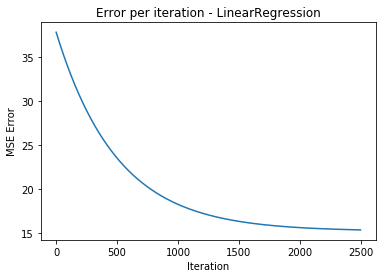

In [89]:
# Model learning history
plt.plot(linear_regression_model.error_history)
plt.title("Error per iteration - LinearRegression")
plt.ylabel('MSE Error')
plt.xlabel('Iteration')
plt.show()

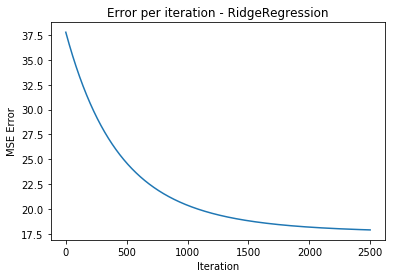

In [90]:
# Model learning history
plt.plot(ridge_regression_model.error_history)
plt.title("Error per iteration - RidgeRegression")
plt.ylabel('MSE Error')
plt.xlabel('Iteration')
plt.show()

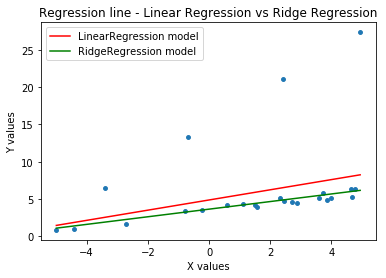

In [91]:
# Displaying dataset
plt.scatter(X, y, s=15)

# Displaying aproximated function
function_x = np.arange(np.min(X), np.max(X), 0.01).reshape(-1, 1)

plt.plot(function_x, linear_regression_model.predict(function_x), c="red", 
         label="LinearRegression model")
plt.plot(function_x, ridge_regression_model.predict(function_x), c="green", 
         label='RidgeRegression model')

plt.title("Regression line - Linear Regression vs Ridge Regression")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend(loc='upper left')
plt.show()